In [ ]:

pip install pmdarima

     |████████████████████████████████| 604 kB 1.0 MB/s eta 0:00:01
  Using cached Cython-0.29.30-py2.py3-none-any.whl (985 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pmdarima
import warnings
warnings.simplefilter('ignore')

In [ ]:
fb = yf.Ticker('FB').history("2y")
len(fb)

504

In [ ]:
fb.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-07-13,160.160004,164.979996,159.612701,163.490005,16555138,0,0
2022-07-14,161.220001,162.589996,157.280106,158.050003,23765168,0,0
2022-07-15,160.539993,164.979996,159.820007,164.699997,23342807,0,0
2022-07-18,166.750000,171.684998,165.639999,167.229996,23574337,0,0
2022-07-19,170.369995,176.490005,169.509995,175.779999,25695348,0,0


In [ ]:
fb = fb.dropna()
fb["Date"] = fb.index

In [ ]:
fb = fb.groupby(fb.index)[['Close']].mean()

In [ ]:
fb.head()

,Close
Date,
2020-07-20,245.419998
2020-07-21,241.750000
2020-07-22,239.869995
2020-07-23,232.600006
2020-07-24,230.710007


In [ ]:
#Dicky Fuller Test
from statsmodels.tsa.stattools import adfuller
print("P value is: " + str(adfuller(fb['Close'])[1]))
print("P value >0.05 , hence data is non stationary")



P value is: 0.7729074630536077
P value >0.05 , hence data is non stationary


In [ ]:
#Differencing to make data stationary
#How many differences required

print(pmdarima.arima.utils.ndiffs(fb['Close'],test='adf'))

1


                 Close  Close First Difference
Date                                          
2020-07-21  241.750000               -3.669998
2020-07-22  239.869995               -1.880005
2020-07-23  232.600006               -7.269989
2020-07-24  230.710007               -1.889999
2020-07-27  233.500000                2.789993


Text(0, 0.5, 'Price')

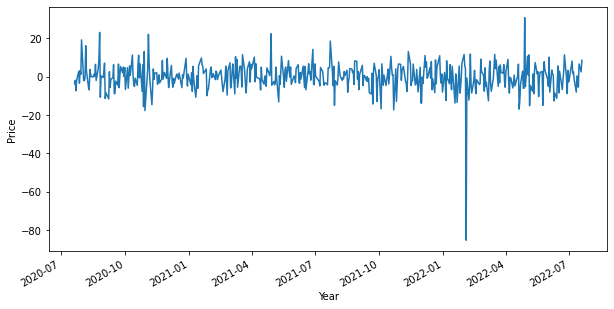

In [ ]:
fb["Close First Difference"] = fb['Close'] - fb['Close'].shift(1)
fb = fb.dropna()
print(fb.head())
fb['Close First Difference'].plot(figsize=(10,5))
plt.xlabel('Year')
plt.ylabel('Price')


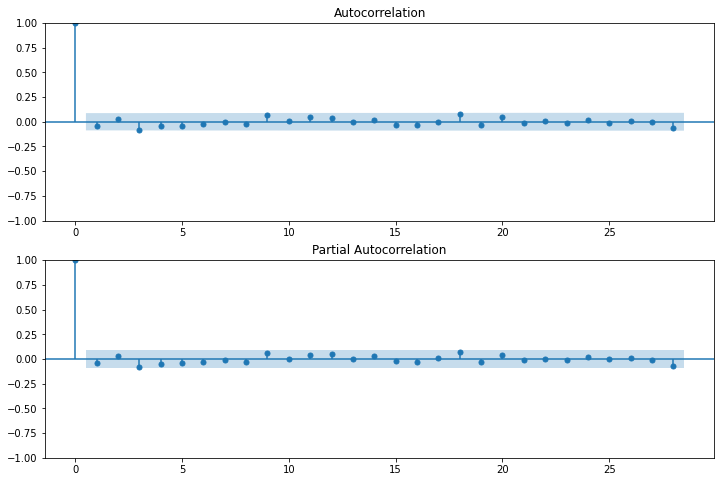

In [ ]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(fb["Close First Difference"].dropna(),ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(fb["Close First Difference"].dropna(),ax=ax2)

In [ ]:
fb

,Close,Close First Difference
Date,,
2020-07-21,241.750000,-3.669998
2020-07-22,239.869995,-1.880005
2020-07-23,232.600006,-7.269989
2020-07-24,230.710007,-1.889999
2020-07-27,233.500000,2.789993
...,...,...
2022-07-13,163.490005,0.220001
2022-07-14,158.050003,-5.440002
2022-07-15,164.699997,6.649994


In [ ]:

print("P value is: " + str(adfuller(fb['Close First Difference'].dropna())[1]))


P value is: 0.0


In [ ]:
predi=[]

r=len(fb)
r = int(r*0.7)
fb_test = np.array(fb['Close'][r:])
for i in range(len(fb_test)):
    l=len(fb)
    l = int(l*0.7)
    fb_train = np.array(fb['Close'][:l+i])
    fb_test = np.array(fb['Close'][l+i:l+i+1])
    stepwise_fit = pmdarima.auto_arima(fb['Close First Difference'][:l+i].dropna(),suppress_warnings=True,d=1)
    a = list(str(stepwise_fit)[7:12:2])
    a = [int(d) for d in a]
    model_fb = sm.tsa.arima.ARIMA(fb_train,order=a)
    result_fb = model_fb.fit()
    start_fb = len(fb_train)
    end_fb = len(fb_train)+len(fb_test)-1
    pred_fb = result_fb.predict(start=start_fb,end=end_fb,typ='levels')
    predi.append(float(pred_fb))






    

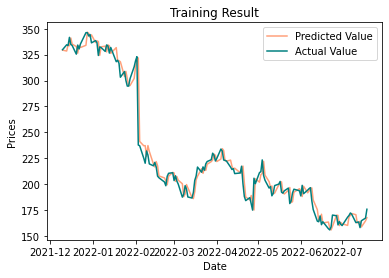

In [ ]:
l=len(fb)
l = int(l*0.7)
fb_test = np.array(fb['Close'][l:])
pred_fb_index = np.array(fb.index[l:])
plt.plot(pred_fb_index,predi,color='lightsalmon')
plt.plot(pred_fb_index,fb_test[:],color='teal')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.title("Training Result")
plt.legend(['Predicted Value','Actual Value'])
plt.show()


In [ ]:
# Predicting Data For The Coming Month(20th July Onwards)
n = len(fb)
predi=[]
for i in range(20):
    fb_train = list(fb['Close'][:n+i])
    stepwise_fit = pmdarima.auto_arima(fb['Close First Difference'][i:n+i].dropna(),suppress_warnings=True,d=1)
    a = list(str(stepwise_fit)[7:12:2])
    a = [int(d) for d in a]
    model_fb = sm.tsa.arima.ARIMA(np.array(fb_train),order=a)
    result_fb = model_fb.fit()
    start_fb = len(fb_train)
    end_fb = len(fb_train)
    pred_fb = result_fb.predict(start=start_fb,end=end_fb,typ='levels')
    pred_fb=pred_fb[0]
    predi.append(float(pred_fb))
    fb_train.append(float(pred_fb))
    df={'Close':float(pred_fb)}
    fb = fb.append(df,ignore_index='True')
    fb["Close First Difference"][n+i] = fb['Close'][n+i] - fb['Close'][n+i-1]

    
    
    



In [ ]:
from datetime import datetime
indexes = pd.date_range(start="2022-07-20",periods=20).to_pydatetime().tolist()
predi

[175.2339856472638,
 175.09069396008817,
 174.03028051541528,
 173.57156497257205,
 173.27650006002267,
 173.39103167099262,
 173.47695626248375,
 173.56369644006355,
 173.586043865886,
 173.5856565184207,
 173.5704311631977,
 173.56146230751295,
 173.55702994987243,
 173.55737438744146,
 173.5587782299172,
 173.56013067775015,
 173.56065466446873,
 173.56070465466436,
 173.56052113038623,
 173.56036397251725]

<function matplotlib.pyplot.show(close=None, block=None)>

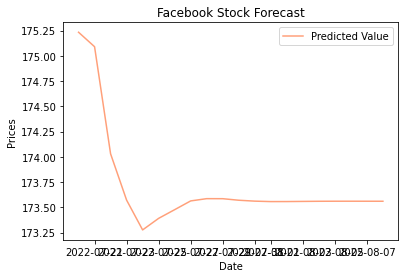

In [ ]:
plt.plot(indexes,predi,color='lightsalmon')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.title("Facebook Stock Forecast")
plt.legend(['Predicted Value'])
plt.show
